# RÉSUMÉ GLOBAL : MÉMO TECHNIQUE (EXAMEN) (CTRL+F)
---

## 1. Unités & Variables Clés
* **Force ($F$)** : Newton [N] ($1 \text{ N} = 1 \text{ kg} \cdot \text{m/s}^2$).
* **Pression ($p$)** : Pascal [Pa] ($1 \text{ bar} = 10^5 \text{ Pa}$).
* **Contrainte ($\sigma$)** : Force par surface ($F/S$) [Pa] ou [N/m²].
* **Déformation ($\epsilon$)** : Allongement relatif ($\Delta L / L$) [sans unité] (souvent en $\mu\epsilon$).
* **Facteur de Jauge ($K$)** : Sensibilité de la jauge ($\Delta R/R = K \cdot \epsilon$).
* **Module de Young ($E$)** : Rigidité. Loi de Hooke : $\sigma = E \cdot \epsilon$.
* **Sensibilité ($S$)** : Rapport Sortie/Entrée (ex: [V/bar], [V/(m/s²)]).
* **Charge ($Q$)** : Coulomb [C] (Pour les capteurs piézoélectriques).

---

## 2. Formules Rapides & Métrologie (Ch. 2-4)
* **Erreur Absolue** : $E = \text{Mesure} - \text{Valeur Vraie}$.
* **Erreur Relative** : $e = E / \text{Valeur Vraie}$.
* **Précision Multimètre** : $\pm(\% \text{Lecture} + \% \text{Gamme} + \text{Digits})$.
* **Résolution Numérique** : $\Delta V = \text{Plage} / 2^N$ ($N$ = nombre de bits).
* **Sensibilité Multivariable** : $\Delta y = \sum \left( \frac{\partial f}{\partial x_i} \cdot \Delta x_i \right)$.
* **Décibels (dB)** : $G_{dB} = 20 \log_{10}(U_{out}/U_{in})$.

---

## 3. Capteurs Spécifiques (Ch. 5-8)
* **Jauges (Pont de Wheatstone)** :
    * *Quart de pont* : $U_m \approx \frac{U_{alim}}{4} K \epsilon$
    * *Demi pont* : $U_m \approx \frac{U_{alim}}{2} K \epsilon$
    * *Pont complet* : $U_m \approx U_{alim} K \epsilon$
* **Piézoélectrique** :
    * $Q = \beta \cdot F$
    * $U = Q / C_{tot}$ avec $C_{tot} = C_{capteur} + C_{cable} + C_{ampli}$.
    * **Bande passante** : Limite haute à $0.2 \cdot f_{résonance}$.
* **RTD (Pt100)** : $R(T) \approx R_0(1 + \alpha T)$ avec $\alpha \approx 0.00385$.
* **Tube de Pitot** : $v = \sqrt{\frac{2 \Delta P}{\rho}}$.

---

## 4. Électricité & Analyse Numérique (Ch. 9-11)
* **RMS ($U_{eff}$)** : Sinus ($U_{max}/\sqrt{2}$), Triangle ($U_{max}/\sqrt{3}$), Carré ($U_{max}$).
* **Puissance AC** : $P_{active} = U_{eff} \cdot I_{eff} \cdot \cos \phi$.
* **Théorème de Shannon** : $f_s > 2 \cdot f_{max}$.
* **Résolution FFT** : $\Delta f = f_s / N = 1 / T_{mesure}$.
* **Fenêtrage** : Hanning (Fréquence), Flat-top (Amplitude).

---
*Projet réalisé avec passion par **OneArctic** & son binôme numérique **Gem**.*


In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
import scipy.signal as signal

# Configuration pour affichage propre
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = '{:,.4f}'.format
sp.init_printing(use_latex='mathjax')
plt.style.use('default')
plt.rcParams.update({
    'axes.grid': True,
    'grid.linestyle': '--',
    'figure.figsize': (8, 5),
    'font.size': 10
})

print("Librairies chargées")

Librairies chargées


# <a id='ch-metrologie'></a> ️ Ch. 2-4 : Métrologie & Calibration
---
**Documents liés :** `Instr_2` (Carac. Statiques), `Instr_3` (Erreurs), `Instr_4` (Régression Linéaire).
**Contenu :** Sensibilité, Linéarité, Justesse, Fidélité et Droite de calibration.

### ÉTHODES DE MESURE & INCERTITUDES PROPAGÉES

**Quand l'utiliser ?**
Cette section remplace le document manquant "Méthodes de mesure". Elle est utilisée pour les **mesures indirectes**, c'est-à-dire quand vous calculez un résultat final à partir de plusieurs capteurs différents.

### **Concepts Clés :**
* **Mesure Directe :** Lecture immédiate sur l'instrument (ex: règle, multimètre).
* **Mesure Indirecte :** Calcul via une loi physique (ex: $P = U \cdot I$ ou $R = U / I$).
* **Méthode de Zéro :** Annulation du signal pour une précision maximale (ex: Pont de Wheatstone à l'équilibre).

### **Formules de Propagation d'Incertitude :**
Pour un résultat calculé $Y = f(A, B)$ :
* **Addition / Soustraction ($Y = A \pm B$) :** $$\Delta Y = \Delta A + \Delta B$$
* **Produit / Quotient ($Y = A \cdot B$ ou $A/B$) :** $$\frac{\Delta Y}{Y} = \frac{\Delta A}{A} + \frac{\Delta B}{B}$$

In [100]:
# --- VALEURS D'ENTRÉE (Exemple : Calcul de R = U / I) ---
# Entrez ici les valeurs lues sur vos appareils
U = 10.0            # Tension mesurée [V]
delta_U = 0.05      # Incertitude absolue du voltmètre (ex: ±0.05V)

I = 0.02            # Courant mesuré [A]
delta_I = 0.001     # Incertitude absolue de l'ampèremètre (ex: ±1mA)

# --- CALCUL DE LA VALEUR NOMINALE ---
# Application de la loi d'Ohm
R = U / I

# --- CALCUL DE L'INCERTITUDE PROPAGÉE (Cas du Quotient) ---
# La règle pour la division est d'additionner les incertitudes RELATIVES
# delta_R / R = (delta_U / U) + (delta_I / I)
incertitude_relative = (delta_U / U) + (delta_I / I)
delta_R = R * incertitude_relative

# --- AFFICHAGE DES RÉSULTATS ---
print(f"--- ANALYSE DE MESURE INDIRECTE (R = U/I) ---")
print(f"Valeur calculée (R)     : {R:.2f} Ω")
print(f"Incertitude absolue (ΔR) : ±{delta_R:.2f} Ω")
print(f"Incertitude relative (%) : {incertitude_relative*100:.2f} %")
print(f"\nRésultat final à noter : R = ({R:.2f} ± {delta_R:.2f}) Ω")

--- ANALYSE DE MESURE INDIRECTE (R = U/I) ---
Valeur calculée (R)     : 500.00 Ω
Incertitude absolue (ΔR) : ±27.50 Ω
Incertitude relative (%) : 5.50 %

Résultat final à noter : R = (500.00 ± 27.50) Ω


### Erreurs & Précision (Multimètre)

**Quand l'utiliser ?**
Pour calculer l'erreur absolue et relative d'un appareil numérique.

**Formules:**
*   **Erreur Totale** = $\pm (\% \text{Lecture} \cdot \text{Valeur} + \% \text{Gamme} \cdot \text{Range} + \text{Digits} \cdot \text{Résolution})$
*   **Erreur Relative** = $\frac{\text{Erreur Totale}}{\text{Valeur Lue}} \cdot 100$

In [101]:
# --- VALEURS D'ENTRÉE ---
lecture = 150.0       # Valeur affichée
gamme = 200.0         # Gamme (Full Scale / Range)
prec_lecture = 1.5    # % de la lecture (Gain error)
prec_gamme = 0.5      # % de la gamme (Offset error) Précision
nb_digits = 2         # Nombre de digits (dgt)
resolution = 0.1      # Valeur d'un digit (ex: 0.1V pour gamme 200.0)

# --- CALCUL ---
err_prop = (prec_lecture / 100.0) * lecture
err_const = (prec_gamme / 100.0) * gamme
err_digit = nb_digits * resolution

erreur_totale = err_prop + err_const + err_digit
erreur_rel = (erreur_totale / lecture) * 100.0 if lecture != 0 else float('inf')

print(f"--- ANALYSE D'ERREUR ---")
print(f"Erreur proportionnelle : {err_prop:.4f}")
print(f"Erreur constante       : {err_const + err_digit:.4f}")
print(f"Output => Erreur Absolue      : +/- {erreur_totale:.4f}")
print(f"Output => Erreur Relative     : +/- {erreur_rel:.2f} %")
print(f"Plage vraie : [{lecture - erreur_totale:.4f} à {lecture + erreur_totale:.4f}]")

--- ANALYSE D'ERREUR ---
Erreur proportionnelle : 2.2500
Erreur constante       : 1.2000
Output => Erreur Absolue      : +/- 3.4500
Output => Erreur Relative     : +/- 2.30 %
Plage vraie : [146.5500 à 153.4500]


### Qualités Métrologiques : Justesse, Fidélité et Hystérésis

**Contexte :** Analyse statistique des performances d'un capteur sur une série de mesures pour déterminer les erreurs systématiques et aléatoires.

**Formules :**
* **Moyenne ($\bar{x}$) :** $\frac{1}{n} \sum_{i=1}^{n} x_i$
* **Justesse (Biais) :** $E_{justesse} = \bar{x} - \text{valeur\_vraie}$
* **Fidélité (Écart-type $\sigma$) :** $\sigma = \sqrt{\frac{1}{n-1} \sum_{i=1}^{n} (x_i - \bar{x})^2}$
* **Hystérésis :** $H = \max|y_{montant} - y_{descendant}|$ pour une même valeur d'entrée

In [102]:
# --- VALEURS D'ENTRÉE ---
valeur_vraie = 10.0  # La valeur réelle théorique (étalon)
# Série de mesures répétées dans les mêmes conditions pour tester la stabilité
mesures = np.array([10.2, 10.1, 10.3, 10.2, 10.2])

# --- CALCUL ---
# 1. Calcul de la moyenne arithmétique de la série
moyenne = np.mean(mesures)

# 2. Calcul du biais systématique (erreur de justesse)
erreur_justesse = moyenne - valeur_vraie

# 3. Calcul de la dispersion (erreur de fidélité via l'écart-type)
# ddof=1 est utilisé pour l'échantillon non biaisé
erreur_fidelite = np.std(mesures, ddof=1)

print(f"--- RÉSULTATS MÉTROLOGIQUES ---")
print(f"Valeur moyenne obtenue : {moyenne:.3f}")
print(f"Erreur de Justesse (Biais) : {erreur_justesse:.3f} (Proche de 0 = Juste)")
print(f"Erreur de Fidélité (Std σ)  : {erreur_fidelite:.3f} (Petit = Fidèle)")

--- RÉSULTATS MÉTROLOGIQUES ---
Valeur moyenne obtenue : 10.200
Erreur de Justesse (Biais) : 0.200 (Proche de 0 = Juste)
Erreur de Fidélité (Std σ)  : 0.071 (Petit = Fidèle)


### Régression Linéaire (Calibration)

**Quand l'utiliser ?**
Pour trouver la sensibilité ($a$) et l'offset ($b$) d'un capteur à partir d'une série de points ($x_i, y_i$).

**Modèle:**
*   $y = a \cdot x + b$
*   $a$ = Pente (Sensibilité)
*   $b$ = Ordonnée à l'origine (Offset)
*   Erreur de linéarité = Écart max entre Modèle et Mesure.

In [103]:
# --- VALEURS D'ENTRÉE ---
# x = Mesurande (ex: Pression [bar])
x_vals = np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
# y = Sortie (ex: Tension [V])
y_vals = np.array([0.35, 0.67, 1.14, 1.84, 2.26, 2.8, 3.26, 3.58, 4.17, 4.68])

# --- CALCUL ---
# np.polyfit renvoie [pente, offset]
coeffs = np.polyfit(x_vals, y_vals, 1)

# EXTRACTION CORRECTE
a_pente = coeffs[0]
b_offset = coeffs[1]

# Calcul du modèle (maintenant a_pente est un simple nombre)
y_model = a_pente * x_vals + b_offset
erreurs = np.abs(y_vals - y_model)
max_err = np.max(erreurs)


print(f"--- CALIBRATION ---")
print(f"Output => Modèle : y = {a_pente:.4f} * x + ({b_offset:.4f})")
print(f"Sensibilité (a) : {a_pente:.4f}")
print(f"Offset (b)      : {b_offset:.4f}")
print(f"y(x)={a_pente:.3f} * x+ {b_offset:.3f}")
print(f"Erreur Max      : {max_err:.4f}")

--- CALIBRATION ---
Output => Modèle : y = 0.4877 * x + (0.0365)
Sensibilité (a) : 0.4877
Offset (b)      : 0.0365
y(x)=0.488 * x+ 0.037
Erreur Max      : 0.1158


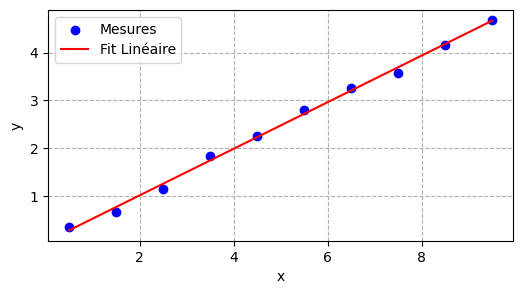

In [104]:
# Graphique
plt.figure(figsize=(6, 3))
plt.scatter(x_vals, y_vals, color='blue', label='Mesures')
plt.plot(x_vals, y_model, color='red', label='Fit Linéaire')
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True); plt.legend(); plt.show()

### Gain en Cascade et Unités (dB)

**Contexte :** Calcul du gain total d'une chaîne de conditionnement composée de plusieurs amplificateurs ou atténuateurs.

**Formules :**
* **Gain Linéaire Total :** $G_{tot} = G_1 \cdot G_2 \cdot \dots \cdot G_n$
* **Gain en Décibels (dB) :** $G_{dB} = 20 \log_{10}(G_{lin})$
* **Somme des dB :** $G_{dB\_tot} = \sum G_{dBi}$

In [105]:
# --- VALEURS D'ENTRÉE ---
# Liste des gains linéaires de chaque étage (ex: x10, x5)
# Laissez la liste vide [] si vous voulez travailler uniquement en dB
gains_lin = [10, 5, 2]

# Liste des gains en décibels (dB) de chaque étage (ex: 20dB, 6dB)
# Laissez vide [] si vous utilisez les gains linéaires ci-dessus
gains_db = []

# --- CALCUL ---
if gains_lin:
    # Le gain total linéaire est le PRODUIT des gains individuels
    g_tot_lin = np.prod(gains_lin)
    # Conversion du gain total en échelle logarithmique (dB)
    g_tot_db = 20 * np.log10(g_tot_lin)
else:
    # Le gain total en dB est la SOMME des gains individuels en dB
    g_tot_db = sum(gains_db)
    # Conversion inverse pour retrouver le coefficient multiplicateur
    g_tot_lin = 10**(g_tot_db / 20)

print(f"--- RÉSULTATS CHAÎNE DE GAIN ---")
print(f"Gain total (multiplicateur) : x{g_tot_lin:.2f}")
print(f"Gain total (échelle dB)      : {g_tot_db:.2f} dB")

--- RÉSULTATS CHAÎNE DE GAIN ---
Gain total (multiplicateur) : x100.00
Gain total (échelle dB)      : 40.00 dB


### Sensibilité Multivariable (Taylor)

**Quand l'utiliser ?**
Pour linéariser une fonction complexe (ex: Masse d'air moteur, Altitude Pitot) autour d'un point de fonctionnement $P_0$.

**Formule:**
$Y \approx Y(P_0) + \frac{\partial F}{\partial x_1}|_{P_0} \cdot (x_1 - x_{1_0}) + \frac{\partial F}{\partial x_2}|_{P_0} \cdot (x_2 - x_{2_0})$

In [106]:
# --- DÉFINITION SYMBOLIQUE ---
# Exemple Source [13]: Masse air moteur m = (Padm - Pres) * Vcyl / (R * Tamb)
Padm, Tamb, R, Vcyl, Pres = sp.symbols('Padm Tamb R Vcyl Pres')
formule = (Padm - Pres) * Vcyl / (R * Tamb)

# Point de fonctionnement (P0)
valeurs_P0 = {
    Padm: 50000,   # 500 mbar = 50000 Pa
    Tamb: 298.15,  # 25°C = 298.15 K
    Pres: 10000,   # 100 mbar
    Vcyl: 0.0005,  # 0.5 L
    R: 287
}

# --- CALCUL ---
# 1. Valeur Nominale
y0 = formule.subs(valeurs_P0)

# 2. Sensibilités (Dérivées partielles)
S_Padm = sp.diff(formule, Padm).subs(valeurs_P0)
S_Tamb = sp.diff(formule, Tamb).subs(valeurs_P0)

print(f"--- Expression ---")
print(f"dm/dPadm = {sp.diff(formule,Padm)}")
print(f"dm/dTamb = {sp.diff(formule,Tamb)}")

print(f"--- LINÉARISATION ---")
print(f"Formule : {formule}")
print(f"Valeur au point P0 (y0) : {y0.evalf():.6f}")
print(f"-"*20)
print(f"Sensibilité / Padm : {S_Padm.evalf():.4e} (dm/dPadm)")
print(f"Sensibilité / Tamb : {S_Tamb.evalf():.4e} (dm/dTamb)")
print(f"Output => y_lin ≈ {y0:.4f} + ({S_Padm:.2e} * dPadm) + ({S_Tamb:.2e} * dTamb)")



--- Expression ---
dm/dPadm = Vcyl/(R*Tamb)
dm/dTamb = -Vcyl*(Padm - Pres)/(R*Tamb**2)
--- LINÉARISATION ---
Formule : Vcyl*(Padm - Pres)/(R*Tamb)
Valeur au point P0 (y0) : 0.000234
--------------------
Sensibilité / Padm : 5.8432e-9 (dm/dPadm)
Sensibilité / Tamb : -7.8393e-7 (dm/dTamb)
Output => y_lin ≈ 0.0002 + (5.84e-9 * dPadm) + (-7.84e-7 * dTamb)


#### <a id='graph-mono'></a> Visualisation : Linéarisation Mono-variable
**Analyse :** Comparaison entre la courbe réelle et son approximation linéaire (tangente) au point de fonctionnement $x_0$.

--- ANALYSE MONO-VARIABLE ---
Équation de la tangente : y = 5.466 + 2.500 * (x - 2.0)
Sensibilité locale au point x0 : 2.5000 V/Bar


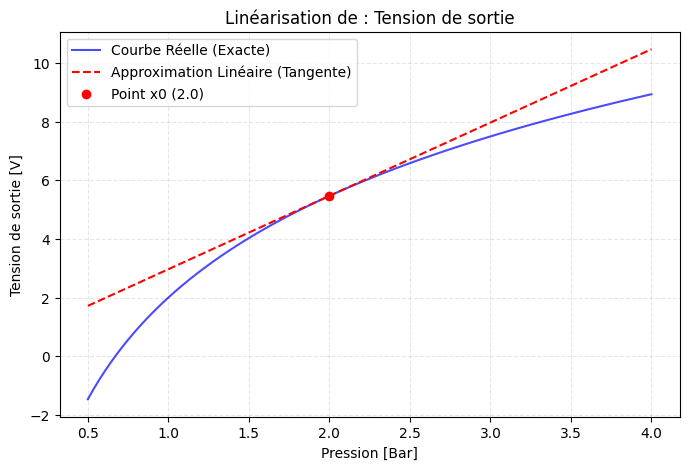

In [107]:
# ==========================================
# 1. CONFIGURATION DU PROBLÈME
# ==========================================
config = {
    "nom_y": "Tension de sortie",
    "unit_y": "V",
    "nom_x": "Pression",
    "unit_x": "Bar",
    "x0": 2.0,            # Point de fonctionnement choisi
    "x_range": [0.5, 4.0] # Plage pour le graphique
}

# Définition de la formule mathématique
x = sp.symbols('x')
# Exemple : y = 5 * log(x) + 2 (Remplacez par votre formule)
formule = 5 * sp.log(x) + 2

# ==========================================
# 2. CALCULS DE LINÉARISATION
# ==========================================
# Valeur nominale au point x0
y0 = float(formule.subs(x, config["x0"]).evalf())

# Sensibilité (Dérivée première f'(x) au point x0)
sensibilite = float(sp.diff(formule, x).subs(x, config["x0"]).evalf())

print(f"--- ANALYSE MONO-VARIABLE ---")
print(f"Équation de la tangente : y = {y0:.3f} + {sensibilite:.3f} * (x - {config['x0']})")
print(f"Sensibilité locale au point x0 : {sensibilite:.4f} {config['unit_y']}/{config['unit_x']}")

# ==========================================
# 3. VISUALISATION
# ==========================================
x_vals = np.linspace(config["x_range"][0], config["x_range"][1], 100)
y_exact = [float(formule.subs(x, val).evalf()) for val in x_vals]
y_lin = y0 + sensibilite * (x_vals - config["x0"])

plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_exact, 'b-', label='Courbe Réelle (Exacte)', alpha=0.7)
plt.plot(x_vals, y_lin, 'r--', label='Approximation Linéaire (Tangente)')
plt.scatter([config["x0"]], [y0], color='red', zorder=5, label=f'Point x0 ({config["x0"]})')

plt.title(f"Linéarisation de : {config['nom_y']}")
plt.xlabel(f"{config['nom_x']} [{config['unit_x']}]")
plt.ylabel(f"{config['nom_y']} [{config['unit_y']}]")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

#### <a id='graph-multi'></a> Visualisation : Sensibilités Multi-variables
**Analyse :** Décomposition de l'influence de chaque variable d'entrée sur le résultat final, calculée par dérivées partielles.

--- ANALYSE MONO-VARIABLE ---
Équation de la tangente : y = 5.466 + 2.500 * (x - 2.0)
Sensibilité locale au point x0 : 2.5000 V/Bar


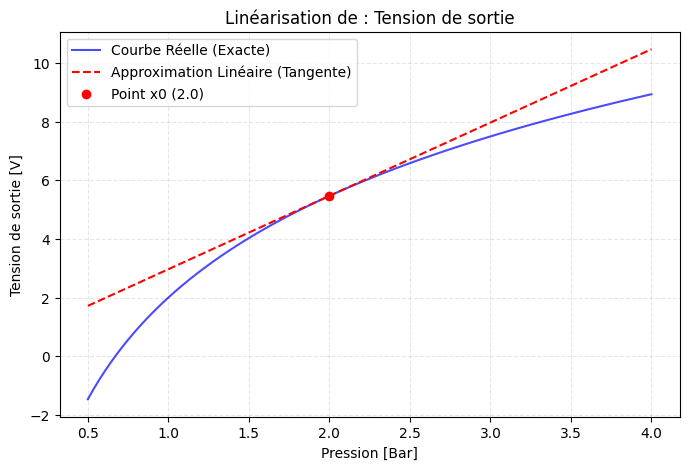

In [108]:
# ==========================================
# 1. CONFIGURATION DU PROBLÈME
# ==========================================
config = {
    "nom_y": "Tension de sortie",
    "unit_y": "V",
    "nom_x": "Pression",
    "unit_x": "Bar",
    "x0": 2.0,            # Point de fonctionnement choisi
    "x_range": [0.5, 4.0] # Plage pour le graphique
}

# Définition de la formule mathématique
x = sp.symbols('x')
# Exemple : y = 5 * log(x) + 2 (Remplacez par votre formule)
formule = 5 * sp.log(x) + 2

# ==========================================
# 2. CALCULS DE LINÉARISATION
# ==========================================
# Valeur nominale au point x0
y0 = float(formule.subs(x, config["x0"]).evalf())

# Sensibilité (Dérivée première f'(x) au point x0)
sensibilite = float(sp.diff(formule, x).subs(x, config["x0"]).evalf())

print(f"--- ANALYSE MONO-VARIABLE ---")
print(f"Équation de la tangente : y = {y0:.3f} + {sensibilite:.3f} * (x - {config['x0']})")
print(f"Sensibilité locale au point x0 : {sensibilite:.4f} {config['unit_y']}/{config['unit_x']}")

# ==========================================
# 3. VISUALISATION
# ==========================================
x_vals = np.linspace(config["x_range"][0], config["x_range"][1], 100)
y_exact = [float(formule.subs(x, val).evalf()) for val in x_vals]
y_lin = y0 + sensibilite * (x_vals - config["x0"])

plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_exact, 'b-', label='Courbe Réelle (Exacte)', alpha=0.7)
plt.plot(x_vals, y_lin, 'r--', label='Approximation Linéaire (Tangente)')
plt.scatter([config["x0"]], [y0], color='red', zorder=5, label=f'Point x0 ({config["x0"]})')

plt.title(f"Linéarisation de : {config['nom_y']}")
plt.xlabel(f"{config['nom_x']} [{config['unit_x']}]")
plt.ylabel(f"{config['nom_y']} [{config['unit_y']}]")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

# <a id='ch-position'></a> Ch. 5-6 : Position & Mouvement
---
**Documents liés :** `Instr_5` (Potentiomètres), `Instr_6` (Codeurs Incrémentaux).
**Contenu :** Effet de charge du potentiomètre et résolution/vitesse des codeurs optiques.

### Potentiomètre Linéaire en Charge

**Énoncé:**
Un potentiomètre de $R_{pot} = 10\text{k}\Omega$ est alimenté par $V_0 = 3.3\text{V}$.
Le curseur est chargé par une résistance $R_L = 5\text{k}\Omega$.
On cherche la tension $U_{out}$ pour les positions du curseur : 0%, 50%, 75%, 100%.

**Théorie:**
Le potentiomètre est divisé en deux résistances par la position du curseur $x$ (de 0 à 1) :
*   $R_{haut} = (1 - a) \cdot R_{pot}$
*   $R_{bas} = a \cdot R_{pot}$

La résistance de charge $R_L$ est en parallèle avec la partie basse $R_{bas}$.
1.  Calculer la résistance équivalente basse : $R_{eq} = R_{bas} // R_L = \frac{R_{bas} \cdot R_L}{R_{bas} + R_L}$
2.  Calculer la tension de sortie (Diviseur de tension) : $U_{out} = V_0 \cdot \frac{R_{eq}}{R_{haut} + R_{eq}}$

<div align="center">
    <img src="Fig/Pot-Charge_Lin.png" width="500px">
    <p><b>Figure 1:</b> Schéma du montage du potentiomètre avec charge RL.</p>
</div>

In [109]:
# --- VALEURS D'ENTRÉE ---
V1 = 3.3            # Tension d'alimentation [V]
R_pot = 10000.0     # Résistance totale du potentiomètre [Ohm]
R_load = 5000.0     # Résistance de charge RL [Ohm]
Pos_mes = 99        # Position du Pot 0-99

# FIX: Créer une plage de 0 à 100% pour voir la courbe
positions_pct = np.linspace(0, 100, 50)

# Listes pour stocker les résultats du graphique
x_plot = []
y_plot = []

# --- CALCUL ---
for pos in positions_pct:
    a = pos / 100.0

    # 1. Résistances du potentiomètre
    R_bas = a * R_pot
    R_haut = (1 - a) * R_pot

    # 2. Résistance équivalente (R_bas // R_load)
    if (R_bas + R_load) == 0:
        R_eq = 0
    else:
        R_eq = (R_bas * R_load) / (R_bas + R_load)

    # 3. Diviseur de tension
    if (R_haut + R_eq) == 0:
        U_out = 0
    else:
        U_out = V1 * (R_eq / (R_haut + R_eq))

    x_plot.append(pos)
    y_plot.append(U_out)


y_ideal = positions_pct / 100.0 * V1
error_linearity = np.max(np.abs(y_ideal - y_plot))
print(f"Erreur de linéarité max: {error_linearity:.4f} V")

print(f"Tension V de sortie a position {Pos_mes+1:.2f} %: {y_plot[ int(Pos_mes/2)]:.2f} V")


Erreur de linéarité max: 0.6832 V
Tension V de sortie a position 100.00 %: 3.30 V


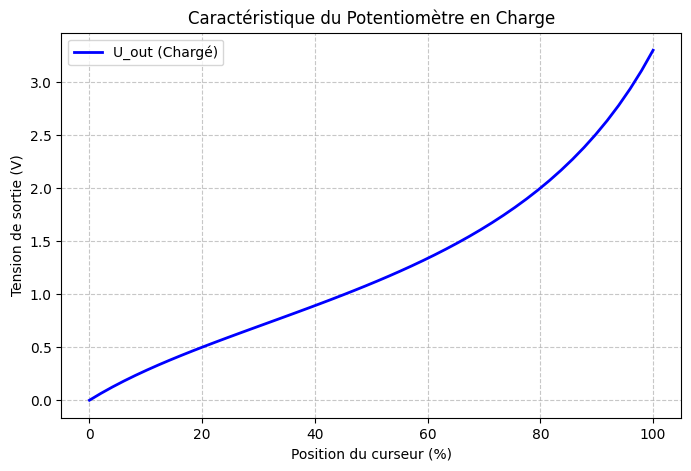

In [110]:
# --- GRAPHIQUE ---
plt.figure(figsize=(8, 5))
plt.style.use('default') # Force le fond blanc

plt.plot(x_plot, y_plot, color='blue', linewidth=2, label='U_out (Chargé)')

# AJOUT DES LABELS ET DE LA GRILLE (Avant plt.show)
plt.title("Caractéristique du Potentiomètre en Charge")
plt.xlabel("Position du curseur (%)")
plt.ylabel("Tension de sortie (V)")
plt.grid(True, linestyle='--', alpha=0.7) # Crée la grille en pointillés
plt.legend()

plt.show()

### Codeur Incrémental : Vitesse & Erreur

**Contexte :** Calcul de la vitesse à partir du comptage d'impulsions sur une période $T_s$, et estimation de l'erreur de quantification.

**Formules :**
*   **Vitesse :** $v = \frac{\Delta \text{Impulsions}}{N_{stries} \cdot T_s}$ (tours/s)
    *   *Note :* Si quadrature x4, remplacer $N_{stries}$ par $4 \cdot N_{stries}$.
*   **Erreur Absolue Vitesse :** $E_{vitesse} = \frac{\Delta \text{Erreur\_Pos}}{T_s}$.
    *   Pire cas (1 bit début + 1 bit fin) : $\Delta \text{Erreur\_Pos} = \frac{2}{N_{total}}$.

<div id="fig-encoder" align="center">
    <img src="Fig/Incremental-Rotary-Encoder-1.jpg" width="600px">
    <p style="color: #7f8c8d; margin-top: 10px;">
        <i><b>Figure 2:</b> Principe de fonctionnement d’un codeur rotatif incrémental optique montrant la génération des signaux A, B et Z.</i>
    </p>
</div>

In [111]:
# --- DONNÉES (Exo Chap 6) ---
N_stries = 512      # Nombre de stries par tour
Ts_ms = 1.0         # Période d'échantillonnage [ms]
Mode_quadrature = 4 # 1 (stries), 2 ou 4 (flancs comptés)

# Simulation d'une lecture
delta_impulsions = 20 # Nombre de coups comptés en 1 ms

# --- CALCULS ---
Ts = Ts_ms / 1000.0
N_total_points = N_stries * Mode_quadrature # Résolution totale par tour

# Vitesse mesurée
vitesse_tr_s = delta_impulsions / (N_total_points * Ts)
vitesse_rpm = vitesse_tr_s * 60

# Erreur de quantification (Pire cas : +/- 1 coup au début et à la fin -> 2 coups)
# Erreur sur le delta compté = 2 incréments (selon certaines sources conservatrices)
# Ou 1 incrément (erreur de +/- 0.5 bit x 2)
# Source [43] utilise: Erreur = 2 * (1/N_points) / Ts
erreur_vitesse_tr_s = 2 * (1 / N_total_points) / Ts

print(f"--- CODEUR INCRÉMENTAL ({N_stries} stries, x{Mode_quadrature}) ---")
print(f"Impulsions comptées : {delta_impulsions} en {Ts_ms} ms")
print(f"Vitesse mesurée     : {vitesse_rpm:.2f} RPM ({vitesse_tr_s:.2f} tr/s)")
print(f"Erreur max vitesse  : +/- {erreur_vitesse_tr_s:.2f} tr/s")

--- CODEUR INCRÉMENTAL (512 stries, x4) ---
Impulsions comptées : 20 en 1.0 ms
Vitesse mesurée     : 585.94 RPM (9.77 tr/s)
Erreur max vitesse  : +/- 0.98 tr/s


### Résolver (Mesure d'Angle Analogique)

**Contexte :** Le rotor est alimenté par une tension sinusoïdale $U_{ref}$. Le stator possède deux bobines à 90° qui récupèrent un signal modulé par l'angle $\theta$.

**Formules des Signaux :**
*   **Excitation (Rotor) :** $U_{ref} = U_0 \sin(\omega t)$
*   **Sortie S1 (Sinus) :** $S_1 = K \cdot U_0 \sin(\omega t) \cdot \sin(\theta)$
*   **Sortie S2 (Cosinus) :** $S_2 = K \cdot U_0 \sin(\omega t) \cdot \cos(\theta)$
    *(Note : K est le rapport de transformation)*

**Boucle de Poursuite (Resolver-to-Digital) :**
Pour trouver l'angle, on utilise un angle estimé $\phi$ (ou $\hat{\theta}$) et on cherche à annuler l'erreur $\epsilon$.
*   **Signal d'Erreur ($\epsilon$) :** $\epsilon = S_1 \cos(\phi) - S_2 \sin(\phi)$
*   **Simplification (Trigo) :** $\epsilon = K U_0 \sin(\omega t) \cdot \sin(\theta - \phi)$
*   Le système asservit $\phi$ jusqu'à ce que $\epsilon = 0$, donc $\phi = \theta$.

In [112]:
# --- DONNÉES (Simulation Résolver) ---
U0 = 10.0           # Amplitude excitation [V]
f_exc = 400.0       # Fréquence porteuse (400Hz à 10kHz typique) [Hz]
K_ratio = 0.5       # Rapport de transformation
Theta_deg = 45.0    # Angle réel du rotor [degrés]
Phi_est_deg = 40.0  # Angle estimé par le système (pour calcul d'erreur) [degrés]

# --- CALCUL DES SIGNAUX (Instantané t) ---
# On se place au pic de la porteuse (sin(wt)=1) pour voir l'amplitude max
omega = 2 * np.pi * f_exc
t_pic = 1 / (4 * f_exc) # Temps pour avoir sin(wt) = 1

# Conversion radians
theta = np.radians(Theta_deg)
phi = np.radians(Phi_est_deg)

# 1. Signaux de sortie (S1, S2)
# S1 est modulé par sin(theta), S2 par cos(theta) [Source 104]
S1_amp = K_ratio * U0 * np.sin(theta)
S2_amp = K_ratio * U0 * np.cos(theta)

# 2. Calcul de l'Angle via Arctan (Méthode statique simple)
# theta = atan(S1 / S2)
angle_calcule_rad = np.arctan2(S1_amp, S2_amp)
angle_calcule_deg = np.degrees(angle_calcule_rad)

# 3. Calcul du Signal d'Erreur (Boucle de poursuite) [Source 106, 111]
# E = S1*cos(phi) - S2*sin(phi)
# Cela correspond à sin(theta - phi)
Erreur_Signal_Amp = S1_amp * np.cos(phi) - S2_amp * np.sin(phi)
Erreur_Theorique = K_ratio * U0 * np.sin(theta - phi)

print(f"--- RÉSOLVER (Angle réel = {Theta_deg}°) ---")
print(f"Amplitude S1 (Sin) : {S1_amp:.4f} V")
print(f"Amplitude S2 (Cos) : {S2_amp:.4f} V")
print(f"Angle recalculé (atan): {angle_calcule_deg:.2f}°")
print(f"-"*30)
print(f"--- BOUCLE DE POURSUITE (Angle estimé = {Phi_est_deg}°) ---")
print(f"L'erreur d'angle est de {Theta_deg - Phi_est_deg}°")
print(f"Signal d'Erreur calculé (E) : {Erreur_Signal_Amp:.4f} V")
print(f"Vérification théorie K*U0*sin(th-ph) : {Erreur_Theorique:.4f} V")
if abs(Erreur_Signal_Amp) > 0.001:
    print("-> Le système doit corriger phi (l'erreur n'est pas nulle).")
else:
    print("-> Le système est verrouillé (Angle trouvé).")

--- RÉSOLVER (Angle réel = 45.0°) ---
Amplitude S1 (Sin) : 3.5355 V
Amplitude S2 (Cos) : 3.5355 V
Angle recalculé (atan): 45.00°
------------------------------
--- BOUCLE DE POURSUITE (Angle estimé = 40.0°) ---
L'erreur d'angle est de 5.0°
Signal d'Erreur calculé (E) : 0.4358 V
Vérification théorie K*U0*sin(th-ph) : 0.4358 V
-> Le système doit corriger phi (l'erreur n'est pas nulle).


# <a id='ch-force-accel'></a> ️ Ch. 7-8 : Accélération & Force
---
**Documents liés :** `Instr_7` (Accéléromètre), `Instr_8` (Force/Couple & Jauges).
**Contenu :** Pont de Wheatstone, Jauges de déformation et Dynamique piézoélectrique.

### Pont de Wheatstone (Résistances)

**Quand l'utiliser ?**
Lorsque l'examen donne quatre valeurs de résistance ($R_1, R_2, R_3, R_4$) et demande la tension de sortie $U_m$ (ou $V_{out}$).

**Formules :**
*   **Diviseur de tension :** $V_{C} = U_0 \frac{R_1}{R_1 + R_2}$ et $V_{D} = U_0 \frac{R_4}{R_3 + R_4}$
*   **Tension de mesure :** $U_m = V_{C} - V_{D}$
*   **Condition d'équilibre :** $R_1 \cdot R_3 = R_2 \cdot R_4$ (si vrai, $U_m = 0$)

**Schéma supposé :**
*   Branche Gauche : $R_2$ (Haut), $R_1$ (Bas)
*   Branche Droite : $R_3$ (Haut), $R_4$ (Bas)


<div id="fig3" align="center">
    <img src="Fig/FIGURE-B1-a-Schema-electrique-du-pont-de-Wheatstone-b-Microphotographie-de-la.png" width="500px">
    <p style="color: #7f8c8d; margin-top: 10px;">
        <i><b>Figure 3:</b> Schéma du Pont de Wheatstone (Ref: Figure-B1-a).</i>
    </p>
</div>

In [113]:
# --- VALEURS D'ENTRÉE ---
U0 = 10.0      # Tension d'alimentation [V]
R1 = 120.0     # Branche Bas-Gauche (entre A et C)
R2 = 120.1     # Branche Haut-Gauche (entre B et C)
R3 = 120.0     # Branche Haut-Droite (entre B et D)
R4 = 119.9     # Branche Bas-Droite (entre A et D)

# --- CALCUL ---
V_C = U0 * (R1 / (R1 + R2))
V_D = U0 * (R4 / (R3 + R4))
Um = V_C - V_D
R_eq = (R1 * R3) - (R2 * R4)

print(f"--- RÉSULTATS PONT ÉLECTRIQUE ---")
print(f"Tension V_gauche : {V_C:.6f} V")
print(f"Tension V_droite : {V_D:.6f} V")
print(f"Output => Tension de sortie Um : {Um:.6f} V ({Um*1000:.3f} mV)")

if abs(R_eq) < 1e-5:
    print("Le pont est ÉQUILIBRÉ.")
else:
    print(f"Le pont est DÉSÉQUILIBRÉ (Déséquilibre R: {R_eq:.4f})")

--- RÉSULTATS PONT ÉLECTRIQUE ---
Tension V_gauche : 4.997918 V
Tension V_droite : 4.997916 V
Output => Tension de sortie Um : 0.000002 V (0.002 mV)
Le pont est DÉSÉQUILIBRÉ (Déséquilibre R: 0.0100)


### Jauges de Contrainte (Strain Gauges)

**Quand l'utiliser ?** Pour calculer la tension de sortie d'un pont ($U_m$) à partir d'une force ($F$), d'une pression ou d'une déformation ($\epsilon$).

### **Formules fondamentales :**
* **Contrainte (Stress) :** $\sigma = F / S$ [Pa]
* **Déformation (Strain) :** $\epsilon = \sigma / E = \Delta L / L$
* **Tensions de sortie ($U_m$) :**
    * *Quart de pont (1 jauge active)* : $U_m \approx \frac{U_0}{4} \cdot K \cdot \epsilon$
    * *Demi pont (2 jauges actives)* : $U_m \approx \frac{U_0}{2} \cdot K \cdot \epsilon$
    * *Pont complet (4 jauges actives)* : $U_m \approx U_0 \cdot K \cdot \epsilon$ (Attention au facteur Poisson $\nu$)


<figure id="fig4" style="text-align: center;">
    <img src="Fig/Jauge_de_def.png" width="500px">
    <figcaption style="color: #7f8c8d; font-size: 0.9em; margin-top: 10px;">
        <b>Figure 4:</b> Schéma de montage d'une jauge de déformation.
        Relation entre allongement mécanique ($\Delta L$) et signal électrique ($U$).
    </figcaption>
</figure>

#### **Instructions d'utilisation du script :**

1. **Configuration du Montage :**
    * Identifiez le nombre de jauges actives sur votre éprouvette.
    * Réglez la variable `type_pont` dans le code (`'quart'`, `'demi'` ou `'complet_poisson'`).

2. **Choix de la Méthode d'Entrée :**
    * Le script supporte quatre méthodes. Choisissez **une seule** option (A, B, C ou D) et laissez les autres à `None`.
    * **Option A :** Déformation ($\epsilon$) connue.
    * **Option B :** Force ($F$) et Section ($S$) connues (le script calcule $\epsilon$ via le module de Young).
    * **Option C :** Géométrie mesurée ($\Delta L$ et $L_0$) comme illustré en **Figure 4**.
    * **Option D :** Variation de résistance mesurée ($\Delta R$ et $R_0$).

3. **Propriétés Matériaux :**
    * Vérifiez le module de Young ($E$) et le coefficient de Poisson ($\nu$).
    * *Exemple :* Acier $\approx 210$ GPa, Aluminium $\approx 70$ GPa.

4. **Résultats :**
    * Exécutez la cellule pour obtenir la tension théorique $U_m$ en Volts et en milliVolts.

In [114]:
# --- VALEURS D'ENTRÉE (Réf: Figure 4) ---
U0 = 10.0           # Alimentation [V] (Uo sur l'image)
K = 2.0             # Facteur de jauge (Gauge Factor)
E_module = 210e9    # Module de Young [Pa] (Acier)
nu = 0.3            # Poisson (Acier)

# --- CHOIX DE L'INPUT (Remplir une seule option, mettre les autres à None) ---
epsilon = None      # Option A : Déformation directe (ex: 1000e-6)
Force = None        # Option B : Force [N] et Section [m2]
L0, dL = 0.1, 1e-5  # Option C : Longueur initiale L0 et Delta L (image Fig 4)
R0, dR = None, None # Option D : Résistance initiale R0 et Delta R (image Fig 4)

Section = 20e-4     # Utiliser avec Option B
type_pont = 'quart' # 'quart', 'demi', 'complet_poisson'

# --- CALCUL DE EPSILON (ε) SELON L'OPTION ---
if epsilon is not None:
    config_input = "Déformation directe"

elif Force is not None:
    sigma = Force / Section
    epsilon = sigma / E_module
    config_input = f"Force ({Force} N)"
    print(f"-> Contrainte calculée : {sigma/1e6:.2f} MPa")

elif L0 is not None and dL is not None:
    # Correspond à dL / Lo sur la Figure 4
    epsilon = dL / L0
    config_input = f"Variation de longueur (dL={dL}m)"

elif R0 is not None and dR is not None:
    # Correspond à (dR / Ro) / K sur la Figure 4
    epsilon = (dR / R0) / K
    config_input = f"Variation de résistance (dR={dR}Ω)"

# --- CALCUL DE LA TENSION DE SORTIE ---
Um = 0
config_pont = ""

if type_pont == 'quart':
    # Formule pour 1 jauge active (Schéma Figure 4)
    Um = (U0 / 4) * K * epsilon
    config_pont = "Quart de pont (1 Jauge)"

elif type_pont == 'demi':
    Um = (U0 / 2) * K * epsilon
    config_pont = "Demi pont (2 Jauges)"

elif type_pont == 'complet_poisson':
    Um = (U0 / 2) * K * epsilon * (1 + nu)
    config_pont = f"Pont Complet (Poisson nu={nu})"

# --- AFFICHAGE ---
print(f"--- RÉSULTATS JAUGES ({config_pont}) ---")
print(f"Méthode d'entrée : {config_input}")
print(f"Déformation (ε)  : {epsilon*1e6:.2f} µm/m")
print(f"Output => Tension Sortie Um : {Um:.6f} V ({Um*1000:.3f} mV)")

--- RÉSULTATS JAUGES (Quart de pont (1 Jauge)) ---
Méthode d'entrée : Variation de longueur (dL=1e-05m)
Déformation (ε)  : 100.00 µm/m
Output => Tension Sortie Um : 0.000500 V (0.500 mV)


### Accéléromètre Piézo

**Contexte :** Calcul complet d'un capteur piézo : Capacité, Charge, Tension, Sensibilité et Fréquence de résonance.

**Formules :**
1.  **Capacité Capteur ($C_q$) :** $C_q = \frac{\epsilon_0 \epsilon_r S}{H} = \frac{\epsilon_0 \epsilon_r \pi D^2}{4 H}$
2.  **Charge ($Q$) :** $Q = \beta \cdot F = \beta \cdot M_s \cdot a$
3.  **Tension ($U$) :** $U = \frac{Q}{C_{tot}} = \frac{Q}{C_q + C_{cable}}$
4.  **Sensibilité ($S$) :** $S = \frac{U}{a} = \frac{\beta M_s}{C_{tot}}$
5.  **Résonance ($f_0$) :** $f_0 = \frac{1}{2\pi}\sqrt{\frac{K}{M_s}}$ avec $K_{cristal} = \frac{E \cdot S}{H}$


**Contexte :** Détermination de la bande passante utile d'un capteur accélérométrique pour éviter la résonance.
**Formules :**
* **Fréquence Propre ($f_0$) :** $f_0 = \frac{1}{2\pi} \sqrt{\frac{k}{m}}$
* **Limite d'utilisation :** En général, $f_{max} \approx 0.2 \cdot f_0$ (pour une erreur < 5%).


In [115]:
# --- DONNÉES (Ex 7.2 Sol [29]) ---
Ms_g = 1.0          # Masse sismique [g]
D_mm = 3.0          # Diamètre cristal [mm]
H_mm = 1.0          # Hauteur cristal [mm]
E_pa = 8e12         # Module Young [Pa]
beta = 2.26e-12     # Coeff piézo [C/N]
C_stray_pF = 2.0    # Capacité parasite [pF]
accel = 1.0         # Accélération test [m/s^2]

# Constantes
eps0 = 8.85e-12
epsR = 4.5

# --- CALCULS ---
# Conversions SI
Ms = Ms_g * 1e-3
D = D_mm * 1e-3
H = H_mm * 1e-3
C_stray = C_stray_pF * 1e-12
Surface = np.pi * (D/2)**2

# 1. Électrique
C_quartz = (eps0 * epsR * Surface) / H
C_total = C_quartz + C_stray

# 2. Mécanique -> Électrique
Force = Ms * accel
Charge = beta * Force
Tension = Charge / C_total
Sensibilite = (beta * Ms) / C_total # V / (m/s^2)

# 3. Résonance (Masse-Ressort)
# Raideur du cristal K = E * S / H
K_cristal = (E_pa * Surface) / H
f0_hz = (1 / (2 * np.pi)) * np.sqrt(K_cristal / Ms)
f_limite = 0.2 * f0_hz


print(f"--- ACCÉLÉROMÈTRE PIÉZO ---")
print(f"Capacité Quartz : {C_quartz*1e12:.2f} pF")
print(f"Capacité Totale : {C_total*1e12:.2f} pF")
print(f"Tension (a={accel} m/s²) : {Tension*1000:.4f} mV")
print(f"Sensibilité     : {Sensibilite*1000:.4f} mV/(m/s²)")
print(f"--- ANALYSE DYNAMIQUE ---")
print(f"Fréquence Propre: {f0_hz/1000:.2f} kHz")
print(f"Bande passante utile conseillée (20% f0) : {f_limite:.2f} Hz")

--- ACCÉLÉROMÈTRE PIÉZO ---
Capacité Quartz : 0.28 pF
Capacité Totale : 2.28 pF
Tension (a=1.0 m/s²) : 0.9906 mV
Sensibilité     : 0.9906 mV/(m/s²)
--- ANALYSE DYNAMIQUE ---
Fréquence Propre: 1196.83 kHz
Bande passante utile conseillée (20% f0) : 239365.37 Hz


#### Capteur Piézoélectrique
**Quand l'utiliser ?**
Pour les accéléromètres ou capteurs de force piézo. Relie Charge ($Q$), Force ($F$) et Tension ($U$).

**Formules:**
*   **Force :** $F = M_s \cdot a$
*   **Charge :** $Q = \beta \cdot F$ (ou $d_{33} \cdot F$)
*   **Capacité Capteur :** $C_q = \frac{\epsilon_0 \epsilon_r S}{h}$
*   **Tension Sortie :** $U = \frac{Q}{C_{tot}}$ avec $C_{tot} = C_q + C_{cable} + C_{ampli}$
*   **Sensibilité :** $S = \frac{U}{a} = \frac{M_s \cdot \beta}{C_{tot}}$

In [116]:
# --- VALEURS D'ENTRÉE (Ex 7.2 Source [5]) ---
beta = 2.26e-12     # Sensibilité charge [C/N]
Ms_kg = 1e-3        # Masse sismique [kg] (1g = 0.001)
accel = 9.81        # Accélération [m/s^2] (1g)

# Capacités
C_cable = 2e-12     # Capacité parasite câble/ampli [F] (ex: 2pF)

# Géométrie Cristal (pour calculer C_interne)
D_mm = 3.0          # Diamètre [mm]
H_mm = 1.0          # Epaisseur [mm]
epsilon_r = 4.5     # Permittivité relative
epsilon_0 = 8.85e-12

# --- CALCUL ---
# 1. Capacité Interne
Surface = np.pi * ((D_mm/1000.0)/2)**2
C_sensor = (epsilon_0 * epsilon_r * Surface) / (H_mm/1000.0)
C_total = C_sensor + C_cable

# 2. Mécanique & Electrique
Force = Ms_kg * accel
Charge_Q = beta * Force
U_out = Charge_Q / C_total

# 3. Sensibilité globale
Sensibilite_S = (beta * Ms_kg) / C_total # [V / (m/s^2)]

print(f"--- RÉSULTATS PIÉZO ---")
print(f"Capacité Capteur : {C_sensor*1e12:.2f} pF")
print(f"Capacité Totale  : {C_total*1e12:.2f} pF")
print(f"Force Appliquée  : {Force:.4f} N")
print(f"Charge Générée   : {Charge_Q:.3e} C")
print(f"Output => Tension Sortie : {U_out:.6f} V")
print(f"Output => Sensibilité    : {Sensibilite_S:.6f} V/(m/s²)")

--- RÉSULTATS PIÉZO ---
Capacité Capteur : 0.28 pF
Capacité Totale  : 2.28 pF
Force Appliquée  : 0.0098 N
Charge Générée   : 2.217e-14 C
Output => Tension Sortie : 0.009718 V
Output => Sensibilité    : 0.000991 V/(m/s²)


### Tube de Pitot (Vitesse Fluide)

**Quand l'utiliser ?**
Pour calculer la vitesse d'un fluide ($v$) à partir d'une différence de pression ($\Delta P$ ou $\Delta h$).

**Formules:**
*   **Bernoulli :** $P_{tot} = P_{stat} + \frac{1}{2} \rho v^2$
*   **Vitesse :** $v = \sqrt{\frac{2 \Delta P}{\rho_{air}}}$
*   **Delta P (Manomètre) :** $\Delta P = \rho_{liquide} \cdot g \cdot \Delta h$

In [117]:
# --- VALEURS D'ENTRÉE ---
delta_h_mm = 50.0       # Hauteur manomètre [mm]
rho_liquide = 1000      # Eau=1000, Mercure=13600 [kg/m3]
rho_air = 1.225         # Air [kg/m3]
g = 9.81

# --- CALCUL ---
delta_h_m = delta_h_mm / 1000.0
# Pression différentielle
Delta_P = rho_liquide * g * delta_h_m

# Vitesse
v = np.sqrt( (2 * Delta_P) / rho_air )

print(f"--- PITOT ---")
print(f"Delta P : {Delta_P:.2f} Pa")
print(f"Output => Vitesse : {v:.2f} m/s ({v*3.6:.1f} km/h)")

--- PITOT ---
Delta P : 490.50 Pa
Output => Vitesse : 28.30 m/s (101.9 km/h)


# <a id='ch-elec'></a> Ch. 9 : Grandeurs Électriques Alternatives
---
**Document lié :** `Instr_9` (RMS, Puissance, Distorsion).
**Contenu :** Rapport Crête/Efficace, Puissance active/apparente et harmoniques.

### Rapport Crête / Efficace

**Question :** Quel est le rapport entre la valeur de crête ($\hat{u}$) et la valeur efficace ($U_{eff}$) d'un signal triangulaire redressé ?

**Théorie :**
*   Le redressement (valeur absolue) ne change pas l'énergie, donc la valeur efficace (RMS) d'un signal triangulaire redressé est la même que celle d'un triangulaire standard.
*   **Formule RMS (Triangle/Dent de scie) :** $U_{eff} = \frac{U_{crête}}{\sqrt{3}}$
*   **Rapport Théorique :** $\frac{U_{crête}}{U_{eff}} = \sqrt{3} \approx 1.732$

In [118]:
t,T,X_pk=sp.symbols("t,T,X_pk", positive=True)
# the triangle is symetric in time, the RMS of the rising part and the falling parts is the s# we define a function for the first part only, and compute the RMS for that part.
v = (t / T) * X_pk

# Use 2 * pi * t / T to ensure integration covers exactly one full cycle
# v = X_pk * sp.sin(2 * sp.pi * (t / T))

RMS=sp.sqrt(sp.integrate(v**2,(t,0,T))/T)
RMS.simplify()



√3⋅Xₚₖ
──────
  3   

# <a id='ch-fft'></a> Ch. 10-11 : FFT & Analyse Numérique
---
**Documents liés :** `Instr_10` (FFT & Aliasing), `Instr_11` (Corrélation).
**Contenu :** Critère de Shannon, Résolution fréquentielle et Fenêtrage spectral.

### Analyse FFT (Spectre)

**Quand l'utiliser ?**
Pour convertir des indices de tableau FFT ($k$) en fréquences ($f$) ou trouver la résolution minimale du spectre.

**Formules:**
* **Résolution :** $\Delta f = \frac{f_s}{N}$
* **Conversion :** $f = k \cdot \Delta f$ et $k = \frac{f}{\Delta f}$
* **Nyquist :** $f_{max} = f_s / 2$ (Index $N/2$)

In [119]:
# --- VALEURS D'ENTRÉE ---
fs = 48000.0          # Fréquence d'échantillonnage [Hz]
measurment_time = 1.0 # Durée de mesure [s]
N_points = fs * measurment_time

# Recherche spécifique (Examen)
target_freq = 1000.0  # Fréquence dont on veut l'index k
target_k = 1300       # Index dont on veut la fréquence f

# --- CALCULS RAPIDES ---
delta_f = fs / N_points
f_nyquist = fs / 2
k_calc = target_freq / delta_f
f_calc = target_k * delta_f

print(f"--- ANALYSE FFT ESSENTIELLE (N={N_points}) ---")
print(f"Résolution (Δf) : {delta_f:.2f} Hz")
print(f"Nyquist (f_max) : {f_nyquist:.2f} Hz")
print(f"Index k pour {target_freq} Hz : {k_calc:.2f}")
print(f"Fréquence pour l'index k={target_k} : {f_calc:.2f} Hz")

--- ANALYSE FFT ESSENTIELLE (N=48000.0) ---
Résolution (Δf) : 1.00 Hz
Nyquist (f_max) : 24000.00 Hz
Index k pour 1000.0 Hz : 1000.00
Fréquence pour l'index k=1300 : 1300.00 Hz


#### Échantillonnage, Aliasing et Fenêtrage
**Contexte :** Vérification du critère de Shannon et calcul de la fréquence apparente ou de l'amplitude réelle du signal.

**Formules et Règles :**
* **Critère de Shannon :** $f_s > 2 \cdot f_{max}$
* **Fréquence repliée (Aliasing) :** $f_{alias} = |f_{signal} - n \cdot f_s|$
* **Amplitude Réelle :** $A = \frac{2 \cdot |raw\_fft|}{N}$ (pour $k \neq 0$)
* **Fenêtrage :** Hanning/Hamming réduit les fuites spectrales au prix d'un élargissement du pic $\Delta f$.

In [120]:
# --- VALEURS D'ENTRÉE SUPPLÉMENTAIRES ---
# Valeur brute issue du tableau FFT (partie réelle ou complexe)
rawfft_target_k = 21120

# --- PROCESSUS FILS : VALIDATION ÉCHANTILLONNAGE ---
is_aliased = target_freq > f_nyquist

# --- CALCUL D'AMPLITUDE ---
# Formule : Amplitude = 2 * |X[k]| / N (sauf pour le continu DC)
k_ampl = 2 * (abs(rawfft_target_k)) / N_points

print(f"--- ANALYSE APPROFONDIE ---")
print(f"1. RAPPORT D'ÉCHANTILLONNAGE :")
if is_aliased:
    # Calcul de la fréquence fantôme (repliée)
    f_alias = abs(target_freq - fs * round(target_freq / fs))
    print(f"   ⚠ALIASING : Le signal à {target_freq}Hz apparaîtra à {f_alias}Hz.")
else:
    print(f"   SHANNON RESPECTÉ : Pas de repliement spectral.")

print(f"\n2. MÉTRIQUES DE SIGNAL (Index k={target_k}) :")
print(f"   Amplitude réelle estimée : {k_ampl:.4f}")
print(f"   Note : L'index k=0 correspond à la composante continue (DC).")

--- ANALYSE APPROFONDIE ---
1. RAPPORT D'ÉCHANTILLONNAGE :
   SHANNON RESPECTÉ : Pas de repliement spectral.

2. MÉTRIQUES DE SIGNAL (Index k=1300) :
   Amplitude réelle estimée : 0.8800
   Note : L'index k=0 correspond à la composante continue (DC).


### Corrélation & Temps de Echo

**Quand l'utiliser ?**
Pour trouver une distance à partir d'un retard (lag) entre un signal émis et reçu (Echo/Sonar).

**Formules:**
*   **Temps :** $\Delta t = \frac{\text{Lag (samples)}}{f_s}$
*   **Distance :** $d = c \cdot \Delta t$ (Direct)
*   **Distance :** $d = \frac{c \cdot \Delta t}{2}$ ou $d = \frac{c \cdot (k - l)} {f_s}$ (Echo/Aller-Retour)
*   $c \approx 340$ m/s (air)

In [121]:
# --- VALEURS D'ENTRÉE ---
fs = 48000.0        # Fréquence échantillonnage [Hz]
c_speed = 343.0     # Vitesse son [m/s]
mode = 'echo'       # 'echo' (/2) ou 'direct'

# Données simulées (Remplacer par chargement de fichier si nécessaire)
N = 1000
sig_emit = np.zeros(N); sig_emit[100:150] = 1
sig_recv = np.zeros(N); sig_recv[185:235] = 0.5 # Retard simulé 85 samples

# --- CALCUL ---
corr = np.correlate(sig_recv, sig_emit, mode='full')
lags = np.arange(-len(sig_emit) + 1, len(sig_recv))

# Trouver le pic
peak_idx = np.argmax(corr)
lag_samples = lags[peak_idx]

# Physique
dt = lag_samples / fs
distance = dt * c_speed
if mode == 'echo': distance /= 2

print(f"--- DISTANCE ({mode}) ---")
print(f"Lag détecté : {lag_samples} échantillons")
print(f"Temps vol   : {dt*1000:.3f} ms")
print(f"Output => Distance : {distance:.4f} m")

--- DISTANCE (echo) ---
Lag détecté : 85 échantillons
Temps vol   : 1.771 ms
Output => Distance : 0.3037 m


# Code Snippet
**_neat and nice to have_**

## Professional Data Display (Pandas & NumPy)

In [122]:
# Force decimal precision for all dataframes
pd.options.display.float_format = '{:.4f}'.format

# Force decimal precision for NumPy printouts
np.set_printoptions(precision=4, suppress=True)

# Example: Displaying your FFT table neatly
data = {'k': [1000, 1250, 1300], 'abs(fft[k])': [17760, 7200, 21120]}
df = pd.DataFrame(data)
display(df)

,k,abs(fft[k])
0,1000,17760
1,1250,7200
2,1300,21120


## Global Matplotlib Styling

ValueError: x and y must be the same size

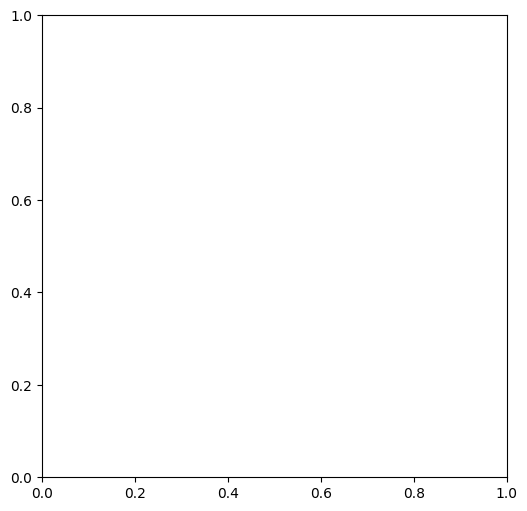

In [124]:
# --- Graphique ---
plt.figure(figsize=(6, 6)) # A square figure size helps with equal scaling
plt.style.use('default')

plt.scatter(x_vals, y_vals, color='blue', label='Mesures')
plt.plot(x_vals, y_model, color='red', label='Fit Linéaire')

# 1. Force the axis limits (Min, Max)
plt.xlim(0, 10)
plt.ylim(0, 10)

# 2. Force equal scaling (1 unit on x = 1 unit on y)
plt.gca().set_aspect('equal', adjustable='box')

plt.grid(True)
plt.legend()
plt.show()
plt.close()

In [25]:
# Force decimal precision for all dataframes
pd.options.display.float_format = '{:.4f}'.format

# Force decimal precision for NumPy printouts
np.set_printoptions(precision=4, suppress=True)

# Example: Displaying your FFT table neatly
data = {'k': [1000, 1250, 1300], 'abs(fft[k])': [17760, 7200, 21120]}
df = pd.DataFrame(data)
display(df)

,k,abs(fft[k])
0,1000,17760
1,1250,7200
2,1300,21120


## Symbolic Math Prettifier (SymPy)

In [26]:
sp.init_printing(use_latex='mathjax') # Makes symbols look professional

# Useful for your RMS work: Define standard symbols once
t, T, X_pk = sp.symbols('t T X_pk', positive=True)

# Function to quickly check RMS
def get_rms(signal_expr, period):
    rms_sq = sp.integrate(signal_expr**2, (t, 0, period)) / period
    return sp.simplify(sp.sqrt(rms_sq))

# Example usage:
v_sine = X_pk * sp.sin(2 * sp.pi * t / T)
display(get_rms(v_sine, T))

√2⋅Xₚₖ
──────
  2   

## Signal Analysis Helper (FFT Mapping)

In [27]:
def fft_info(fs, N):
    df = fs / N
    print(f"--- FFT Specs ---")
    print(f"Resolution (Δf): {df} Hz")
    print(f"Nyquist Limit:   {fs/2} Hz")
    return df

# Usage:
delta_f = fft_info(fs=48000, N=48000)
# Find frequency of index 1300
print(f"Freq at k=1300: {1300 * delta_f} Hz")

--- FFT Specs ---
Resolution (Δf): 1.0 Hz
Nyquist Limit:   24000.0 Hz
Freq at k=1300: 1300.0 Hz


## ANALYSE SPECTRALE AVANCÉE (FFT & FENÊTRAGE)
---
**Quand l'utiliser ?**
Pour analyser le contenu fréquentiel d'un signal complexe (ex: vibrations, sons), identifier des harmoniques, ou traiter des données provenant d'un fichier externe (CSV).

### **Théorie du Fenêtrage (Windowing) :**
Le fenêtrage permet de réduire la **fuite spectrale** (spectral leakage) au prix d'un élargissement du lobe principal :
* **Rectangulaire (Aucun) :** $\Delta f$ minimal (pic fin), mais fortes fuites spectrales.
* **Hanning / Hamming :** Réduit les lobes secondaires pour mieux séparer les pics proches.
* **Flat-top :** Indispensable pour la précision de l'amplitude (erreur < 0.01%).

**Formules Clés :**
* **Résolution :** $\Delta f = \frac{f_s}{N}$
* **Amplitude corrigée :** $A = \frac{2 \cdot |X[k]|}{N} \cdot \text{Facteur\_Fenêtre}$

[Image comparing FFT window functions rectangular vs hanning vs flat-top in time and frequency domain]

### Sous-Module A : Importation et Paramétrage
**Contexte :** Chargement des données brutes et calcul automatique des caractéristiques du signal ($f_s, N, \Delta f$).

In [28]:
# --- ÉTAPE 1 : VALEURS D'ENTRÉE (CSV OU SIMULATION) ---
# Simulation d'un signal pour l'exemple
# Remplacez par : raw_data = pd.read_csv('data.csv')['column_name'].values
fs = 48000.0  # Fréquence d'échantillonnage théorique [Hz]
t = np.linspace(0, 1.0, int(fs), endpoint=False) # 1 seconde de mesure
raw_data = np.sin(2 * np.pi * 1000 * t) + 0.5 * np.sin(2 * np.pi * 2500 * t)

# --- CALCUL DES PARAMÈTRES RÉELS ---
N = len(raw_data)          # Nombre total de points
duration = N / fs          # Durée totale de l'acquisition [s]
delta_f = fs / N           # Résolution fréquentielle (pas entre deux bins)
f_nyquist = fs / 2         # Fréquence maximale mesurable sans aliasing

print(f"--- CARACTÉRISTIQUES DE L'ACQUISITION ---")
print(f"Nombre de points (N)    : {N}")
print(f"Résolution (Δf)         : {delta_f:.2f} Hz")
print(f"Limite de Nyquist       : {f_nyquist} Hz")

--- CARACTÉRISTIQUES DE L'ACQUISITION ---
Nombre de points (N)    : 48000
Résolution (Δf)         : 1.00 Hz
Limite de Nyquist       : 24000.0 Hz


### Sous-Module B : Fenêtrage et Calcul FFT
**Contexte :** Application d'une fenêtre de pondération pour optimiser la précision de l'amplitude et réduire le bruit.

**Comparaison des Fenêtres (Avantages & Inconvénients)**
Le choix de la fenêtre dépend de ce que vous privilégiez : la précision de la fréquence ou la précision de l'amplitude.
| Fenêtre | Points Forts (Pros) | Points Faibles (Cons) | Utilisation Type |
| :--- | :--- | :--- | :--- |
| **Rectangulaire** | Excellente résolution fréquentielle (pic très étroit). | Fortes fuites spectrales (lobes secondaires élevés). | Signaux transitoires qui s'éteignent avant la fin du temps $T$. |
| **Hanning / Hamming** | Très bon filtrage du bruit et réduction des fuites spectrales. | Élargissement modéré du pic principal ($\Delta f$ moins précis). | Signaux aléatoires ou bruits à large bande. |
| **Flat-top** | Précision maximale de l'amplitude (pas d'erreur de gain). | Résolution fréquentielle médiocre (pic très large). | Calibration de capteurs et métrologie de précision. |

--- RÉSULTATS DU SPECTRE (Fenêtre : hann) ---
Fréquence dominante : 1000.00 Hz (Index k=1000)
Amplitude réelle    : 1.0000


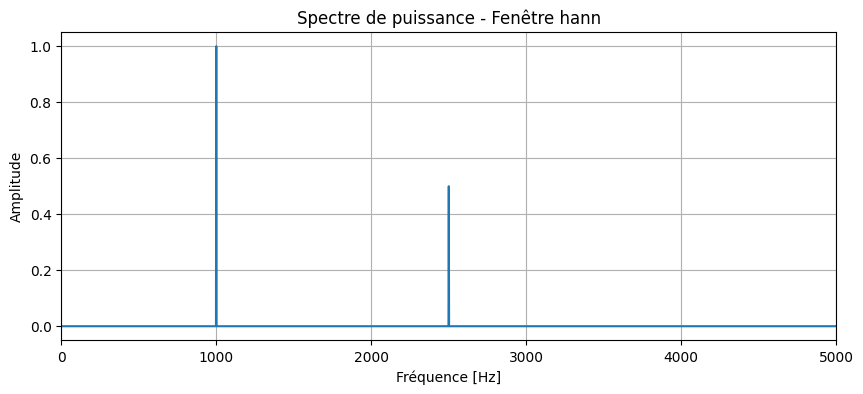

In [29]:
# --- ÉTAPE 2 : CHOIX DU FENÊTRAGE ---
# Options : 'boxcar' (Rect), 'hann' (Hanning), 'hamming', 'flattop'
window_choice = 'hann'

# --- CALCUL DE LA FFT ---
# 1. Génération et application de la fenêtre sur le signal temporel
win = signal.get_window(window_choice, N)
windowed_signal = raw_data * win

# 2. Calcul de la FFT réelle (rfft est plus rapide pour les signaux réels)
fft_values = np.fft.rfft(windowed_signal)
frequencies = np.fft.rfftfreq(N, 1/fs)

# 3. Normalisation de l'amplitude
# On divise par la somme de la fenêtre pour corriger l'atténuation du fenêtrage
amplitudes = 2.0 * np.abs(fft_values) / np.sum(win)

# --- EXTRACTION DES PICS ---
idx_max = np.argmax(amplitudes)
f_max = frequencies[idx_max]
a_max = amplitudes[idx_max]

print(f"--- RÉSULTATS DU SPECTRE (Fenêtre : {window_choice}) ---")
print(f"Fréquence dominante : {f_max:.2f} Hz (Index k={idx_max})")
print(f"Amplitude réelle    : {a_max:.4f}")

# Graphique de vérification
plt.figure(figsize=(10, 4))
plt.plot(frequencies, amplitudes)
plt.title(f"Spectre de puissance - Fenêtre {window_choice}")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Amplitude")
plt.xlim(0, 5000) # Zoom sur la zone utile
plt.grid(True)
plt.show() # Affiche le graphique
plt.close() # Libère la mémoire graphique

# Exam code